# 1. Introduction

Deep Convolutional Neural Networks changed significantly the research landscape for image classification [[1]](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). As more levels were added the expressiveness of the model increased; it was able to learn more complex representations. At some point in time, there seems to be a positive correlation between the depth of the network and the accuracy of the model. In the way was the vanishing/exploding gradient problem that was worsened as the networks were going deeper. Normalized initialization and intermediate normalization layers eventually solved that problem and the deep networks start to converge. As opposed to what was the intuitive reasoning before the experimentations that followed, the accuracy of the models with increasing depth started to saturate and then actually degrading rapidly. It was not due to overfitting but to limitations of the current solvers used to optimize the models [[2]](https://arxiv.org/pdf/1512.03385.pdf).

The degradation problem was partially solved by the introduction of residual networks [[2]](https://arxiv.org/pdf/1512.03385.pdf). It introduced a systematic approach to use *shortcut connections*, connections that skip one or more layers. These *short connections* are simply performing identity mapping, and their outputs are added to the outputs of the stacked layers (which does not add extra parameters or computational complexity). The idea behind it was that if multiple nonlinear layers could asymptotically approximate complicated functions (still being studied theoretically but foundational to deep learning) the same could happen with a residual function. The advantage is that, at the same time, the work of the solvers is simplified. Other types of connections were studied in [[3]](https://arxiv.org/abs/1603.05027), such as skip connections of scaling, gating and 1x1 convolutions, nevertheless, identity mapping continues to yield the lowest training loss.

Our task is to classify a series of labeled images. We want to compare the accuracy of two different approaches, the first is a classical Convolutional Neural Network and the second is a Residual Network. Our goal is to show the power of the Residual Networks even in not so deep settings. It is a good way to help the optimization process, while solving the degradation problem. We empirically tested the Residual Network and it was more prone to overfitting. To solve this problem, we synthetically inflated our dataset by using a strategy of Data Augmentation.

Once again, we use the Simpsons characters dataset [[4]](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset). We filtered the dataset only to contain classes (characters) that contained more than 100 images. After the split between train, validation, and test datasets, the resulting size of the dataset is the following: 12411 images for training, 3091 images for validation, and 950 for testing.

# 2. Data Preprocessing

We create generators to feed our data to the model. We also apply a transformation to normalize the data, split them between training and validation datasets, and define a batch size of 32 (see [[5]](https://towardsdatascience.com/transfer-learning-and-data-augmentation-applied-to-the-simpsons-image-dataset-e292716fbd43) to get a better understanding of the preprocessing and on generators).

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, BatchNormalization, Conv2D, Dense, Flatten, Add, Dropout, BatchNormalization
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import time

In [2]:
directory_train = "./simpsons_data_split/train/"
directory_test = "./simpsons_data_split/test/"

In [3]:
def get_ImageDataGenerator(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                         validation_split=validation_split)
    return image_generator

image_gen_train = get_ImageDataGenerator(validation_split=0.2)

def get_generator(image_data_generator, directory, train_valid=None, seed=None):
    train_generator = image_data_generator.flow_from_directory(directory, 
                                                               batch_size=32, 
                                                               class_mode='categorical', 
                                                               target_size=(128,128), 
                                                               subset=train_valid, 
                                                               seed=seed)    
    return train_generator

train_generator = get_generator(image_gen_train, directory_train, train_valid='training', seed=1)
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')

Found 12411 images belonging to 19 classes.
Found 3091 images belonging to 19 classes.


We also created an inflated dataset to reduce the probability of overfitting, by applying a set of geometric and photometric transformations. Geometric transformations alter the geometry of the image, making the CNN invariant to change in position and orientation. Photometric transformations make the CNN invariant to changes in color and lighting by adjusting the color channels of the image.

In [18]:
def get_ImageDataGenerator_augmented(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        brightness_range=[0.8,1.2],
                                        horizontal_flip=True,
                                        validation_split=validation_split)
    return image_generator
image_gen_train_aug = get_ImageDataGenerator_augmented(validation_split=0.2)
train_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='training', seed=1)
validation_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='validation')

Found 12411 images belonging to 19 classes.
Found 3091 images belonging to 19 classes.


We can iterate through our generators to get a set of images with a size equal to the batch size defined above.

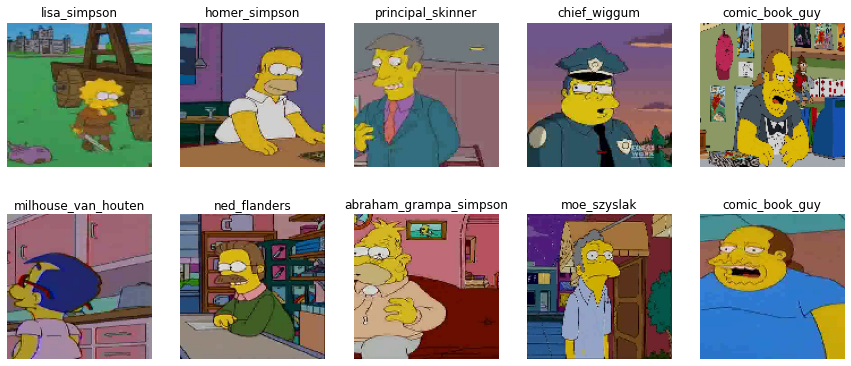

In [4]:
target_labels = next(os.walk(directory_train))[1]

target_labels.sort()

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

target_labels = np.asarray(target_labels)

plt.figure(figsize=(15,10))
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

# 3. Benchmark Model

We define a simple CNN to be used as a benchmark model. It uses a combination of 2D convolution layers (to perform spatial convolution over images) with max-pooling operations. These are followed by a dense layer with 128 units and a ReLU activation function and a dropout layer with a rate of 0.5. Finally, the last layer yields the output of our network, which has a number of units equal to the number of target labels and uses a softmax activation function. The model was compiled with the Adam optimizer with the default settings and categorical cross-entropy loss.

In [5]:
def get_benchmark_model(input_shape):
    x = Input(shape=input_shape)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(.5)(h)
    output = Dense(target_labels.shape[0], activation='softmax')(h)

    model = tf.keras.Model(inputs=x, outputs=output)
    
    model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    return model

In [6]:
benchmark_model = get_benchmark_model((128, 128, 3))
benchmark_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       73856 

In [7]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size
    
    earlystopping = tf.keras.callbacks.EarlyStopping(patience=3)
    history = model.fit(train_gen, 
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        validation_data=valid_gen, 
                        callbacks=[earlystopping])
    
    return history

In [8]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training')
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')
history_benchmark = train_model(benchmark_model, train_generator, validation_generator, 50)

Found 12411 images belonging to 19 classes.
Found 3091 images belonging to 19 classes.
Epoch 1/50
387/387 [==============================] - 139s 357ms/step - loss: 2.7674 - accuracy: 0.1370 - val_loss: 2.1717 - val_accuracy: 0.3488
Epoch 2/50
387/387 [==============================] - 136s 352ms/step - loss: 2.0837 - accuracy: 0.3757 - val_loss: 1.7546 - val_accuracy: 0.4940
Epoch 3/50
387/387 [==============================] - 130s 335ms/step - loss: 1.5967 - accuracy: 0.5139 - val_loss: 1.3483 - val_accuracy: 0.6102
Epoch 4/50
387/387 [==============================] - 130s 335ms/step - loss: 1.1952 - accuracy: 0.6348 - val_loss: 1.1623 - val_accuracy: 0.6619
Epoch 5/50
387/387 [==============================] - 130s 337ms/step - loss: 0.9164 - accuracy: 0.7212 - val_loss: 1.0813 - val_accuracy: 0.6907
Epoch 6/50
387/387 [==============================] - 130s 336ms/step - loss: 0.7270 - accuracy: 0.7802 - val_loss: 1.0241 - val_accuracy: 0.7240
Epoch 7/50
387/387 [=================

# 4. Residual Network

Deep residual networks consist of many stacked *residual units*, that can be defined as,

$$\begin{aligned}
\textbf{y}_l=h(\textbf{x}_l)+ \mathcal{F}(\textbf{x}_l, W_t) \\
\textbf{x}_{l+1} = f(\textbf{y}_l),
\end{aligned}$$

where $\textbf{x}_{l}$ and $\textbf{x}_{l+1}$ are input and output of the l-th unit, $\mathcal{F}$ is a residual function, $h(\textbf{x}_{l})$ is an identity mapping and $f$ is an activation function. $W_t$ is a set of weights (and biases) associated with the l-th *residual unit*. The number of layers proposed by [[2]](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) was 2 or 3. We defined $\mathcal{F}$ as a stack of two $3x3$ convolutional layers. In [[2]](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) $f$ was a ReLU function applied after the element-wise addition. We followed the later proposed architecture by [[3]](https://arxiv.org/abs/1603.05027), where $f$ was just an identity mapping. In this case, $\textbf{x}_{l+1} \equiv\textbf{y}_t$ and we can write,

$$ \textbf{x}_{l+1} = \textbf{x}_l + \mathcal{F}(\textbf{x}_t, W_t),$$

or even more generally,

$$ \textbf{x}_{L} = \textbf{x}_l + \sum^{L-1}_{i=l}\mathcal{F}(\textbf{x}_i, W_i),$$

for any deeper unit $L$ and shallower unit $l$. The feature $ \textbf{x}_{L} = \textbf{x}_0 + \sum^{L-1}_{i=0}\mathcal{F}(\textbf{x}_i, W_i)$, of any deep unit $L$, is then the summation of the outputs of all preceding residual functions plus $\textbf{x}_0$.

In terms of the optimization process, the backward propagation properties give some intuitions about why this type of connection helps in the optimization procedure. We can write it as:

$$\partial \mathcal{L} =\frac{\partial \mathcal{L}}{\partial \textbf{x}_L}\frac{\partial \textbf{x}_L}{\partial \textbf{x}_l} =\frac{\partial \mathcal{L}}{\partial \textbf{x}_L}\left( 1+\frac{\partial}{\partial \textbf{x}_L} \sum^{L-1}_{i=l}\mathcal{F}(\textbf{x}_i, W_i) \right), $$

where $\mathcal{L}$ is the loss function. Notice that the gradient $\frac{\partial \mathcal{L}}{\partial \textbf{x}_L}$ propagates information directly while the term $\frac{\partial \mathcal{L}}{\partial \textbf{x}_L} \left( \frac{\partial}{\partial \textbf{x}_L} \sum^{L-1}_{i=l}\mathcal{F}(\textbf{x}_i, W_i) \right)$ propagates it through the weight layers. It can be shown that with this form the gradient of a layer does not vanish even when the weights are arbitrarily small.

## 4.1 Residual Unit

We use layer subclassing to build the *residual unit*. The custom layer class has 3 methods: `__init__`, `build` and `call`. The `__init__` method calls the base `Layer` class initializer with the defined keyword arguments. The `build` method creates the layers. In our case, we defined two groups of `BatchNormalization` followed by a `Conv2D` layers, the last uses the same number of filters as the layer input. The `call` method processes the inputs through the layers. In our case, we have the following sequence: first `BatchNormalization`, ReLu activation function, first `Conv2D`, second `BatchNormalization`, another ReLu activation function, second `Conv2D`. Finally, we add the inputs to the outputs of the second `Conv2D` layer, which can be seen as the implementation of the *short connection* that performs identity mapping. 

In [9]:
class ResidualUnit(Layer):
    def __init__(self, **kwargs):
        super(ResidualUnit, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.bn_1 = tf.keras.layers.BatchNormalization(input_shape=input_shape)
        self.conv2d_1 = tf.keras.layers.Conv2D(input_shape[3], (3, 3), padding='same')
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.conv2d_2 = tf.keras.layers.Conv2D(input_shape[3], (3, 3), padding='same')
        
    def call(self, inputs, training=False):
        x = self.bn_1(inputs, training)
        x = tf.nn.relu(x)
        x = self.conv2d_1(x)
        x = self.bn_2(x, training)
        x = tf.nn.relu(x)
        x = self.conv2d_2(x)
        x = tf.keras.layers.add([inputs, x])
        return x

In [10]:
test_model = tf.keras.Sequential([ResidualUnit(input_shape=(128, 128, 3), name="residual_unit")])
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_unit (ResidualUnit) (None, 128, 128, 3)       192       
Total params: 192
Trainable params: 180
Non-trainable params: 12
_________________________________________________________________


## 4.2 Residual Unit with increase dimensions

In the architecture proposed by [[2]](https://arxiv.org/pdf/1512.03385.pdf), there are *residual units* that increase dimensions. This is performed by using a linear projection $W_s$ by the shortcut connections to match the desired dimensions:

$$ \textbf{x}_{l+1} = W_s\textbf{x}_l + \mathcal{F}(\textbf{x}_t, W_t).$$

In this case, it is done by a 1x1 convolution layer.

In [11]:
class FiltersChangeResidualUnit(Layer):

    def __init__(self, out_filters, **kwargs):
        super(FiltersChangeResidualUnit, self).__init__(**kwargs)
        self.out_filters = out_filters
        
        
    def build(self, input_shape):
        number_filters = input_shape[0]
        self.bn_1 = tf.keras.layers.BatchNormalization(input_shape=input_shape)
        self.conv2d_1 = tf.keras.layers.Conv2D(input_shape[3], (3, 3), padding='same')
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.conv2d_2 = tf.keras.layers.Conv2D(self.out_filters, (3, 3), padding='same')
        self.conv2d_3 = tf.keras.layers.Conv2D(self.out_filters, (1, 1))
        
        
    def call(self, inputs, training=False):
        x = self.bn_1(inputs, training)
        x = tf.nn.relu(x)
        x = self.conv2d_1(x)
        x = self.bn_2(x, training)
        x = tf.nn.relu(x)
        x = self.conv2d_2(x)
        x_1 = self.conv2d_3(inputs)
        x = tf.keras.layers.add([x, x_1])
        return x   

In [12]:
test_model = tf.keras.Sequential([FiltersChangeResidualUnit(16, input_shape=(32, 32, 3), name="fc_resnet_unit")])
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_resnet_unit (FiltersChang (None, 32, 32, 16)        620       
Total params: 620
Trainable params: 608
Non-trainable params: 12
_________________________________________________________________


## 4.3 Model

Finally, we can build the complete model. We start by defining a `Conv2D` layer with 32 filters, 7x7 kernel and a stride of 2. Following the first layer we add our *residual unit*. Then, we add a new `Conv2D` layer with 32 filters, 3x3 kernel and a stride of 2. Afterward, we add our *residual unit* that allows changing dimensions with an output of 64. To finalize our model we flatten the data and feed it to a `Dense` layer with a softmax activation function and the same number of units as the number of classes.

In [13]:
class ResNetModel(Model):

    def __init__(self, **kwargs):
        super(ResNetModel, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(32, (7, 7), strides=(2,2))
        self.resb = ResidualUnit()
        self.conv2d_2 = tf.keras.layers.Conv2D(32, (3, 3), strides=(2,2))
        self.filtersresb = FiltersChangeResidualUnit(64)
        self.flatten_1 = tf.keras.layers.Flatten()
        self.dense_o = tf.keras.layers.Dense(target_labels.shape[0], activation='softmax')   
        
    def call(self, inputs, training=False):
        x = self.conv2d_1(inputs)
        x = self.resb(x, training)
        x = self.conv2d_2(x)
        x = self.filtersresb(x, training)
        x = self.flatten_1(x)
        x = self.dense_o(x)
        
        return x

In [14]:
resnet_model = ResNetModel()
resnet_model(inputs= tf.random.normal((32, 128,128,3)))
resnet_model.summary()

Model: "res_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            multiple                  4736      
_________________________________________________________________
residual_unit (ResidualUnit) multiple                  18752     
_________________________________________________________________
conv2d_7 (Conv2D)            multiple                  9248      
_________________________________________________________________
filters_change_residual_unit multiple                  30112     
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  1094419   
Total params: 1,157,267
Trainable params: 1,157,011
Non-trainable params: 256
_________________________________________

In [15]:
optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy()

In [16]:
@tf.function
def grad(model, inputs, targets, loss):
    with tf.GradientTape() as tape:
        preds = model(inputs)
        loss_value = loss(targets, preds)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [17]:
def train_resnet(model, num_epochs, dataset, valid_dataset, optimizer, loss, grad_fn):

    train_steps_per_epoch = dataset.n // dataset.batch_size
    train_steps_per_epoch_valid = valid_dataset.n // valid_dataset.batch_size

    train_loss_results = []
    train_accuracy_results = []
    train_loss_results_valid = []
    train_accuracy_results_valid = []
    for epoch in range(num_epochs):
        start = time.time()
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
        epoch_loss_avg_valid = tf.keras.metrics.Mean()
        epoch_accuracy_valid = tf.keras.metrics.CategoricalAccuracy()
        i=0
        for x, y in dataset:
            loss_value, grads = grad_fn(model, x, y, loss)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            epoch_loss_avg(loss_value)
            epoch_accuracy(y, model(x))
            if i>=train_steps_per_epoch:
                break
            i+=1
        j = 0
        for x, y in valid_dataset:
            model_output = model(x)
            epoch_loss_avg_valid(loss_obj(y, model_output))  
            epoch_accuracy_valid(y, model_output)
            if j>=train_steps_per_epoch_valid:
                break
            j+=1

        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())
        train_loss_results_valid.append(epoch_loss_avg_valid.result())
        train_accuracy_results_valid.append(epoch_accuracy_valid.result())
        
        print("Training -> Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                   epoch_loss_avg.result(),
                                                                   epoch_accuracy.result()))
        print("Validation -> Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                           epoch_loss_avg_valid.result(),
                                                           epoch_accuracy_valid.result()))
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
    
    return train_loss_results, train_accuracy_results

In [19]:
train_loss_results, train_accuracy_results = train_resnet(resnet_model, 
                                                          40, 
                                                          train_generator_aug,
                                                          validation_generator_aug,
                                                          optimizer_obj, 
                                                          loss_obj, 
                                                          grad)

Training -> Epoch 000: Loss: 2.654, Accuracy: 27.153%
Validation -> Epoch 000: Loss: 2.532, Accuracy: 23.488%
Time taken for 1 epoch 137.62 sec

Training -> Epoch 001: Loss: 2.205, Accuracy: 39.570%
Validation -> Epoch 001: Loss: 2.124, Accuracy: 36.914%
Time taken for 1 epoch 137.29 sec

Training -> Epoch 002: Loss: 2.010, Accuracy: 46.257%
Validation -> Epoch 002: Loss: 2.074, Accuracy: 40.925%
Time taken for 1 epoch 137.23 sec

Training -> Epoch 003: Loss: 1.818, Accuracy: 52.155%
Validation -> Epoch 003: Loss: 1.904, Accuracy: 45.390%
Time taken for 1 epoch 137.20 sec

Training -> Epoch 004: Loss: 1.663, Accuracy: 57.223%
Validation -> Epoch 004: Loss: 1.711, Accuracy: 50.890%
Time taken for 1 epoch 137.00 sec

Training -> Epoch 005: Loss: 1.549, Accuracy: 62.058%
Validation -> Epoch 005: Loss: 1.635, Accuracy: 52.701%
Time taken for 1 epoch 137.69 sec

Training -> Epoch 006: Loss: 1.379, Accuracy: 66.224%
Validation -> Epoch 006: Loss: 1.500, Accuracy: 56.519%
Time taken for 1 epo

# 5. Results

The residual network showed better accuracy on the test set, with close to 81% of accuracy against 75.6% of the benchmark model. We could easily make the residual model deeper and that is the scenario where we can extract most of the value from this architecture.

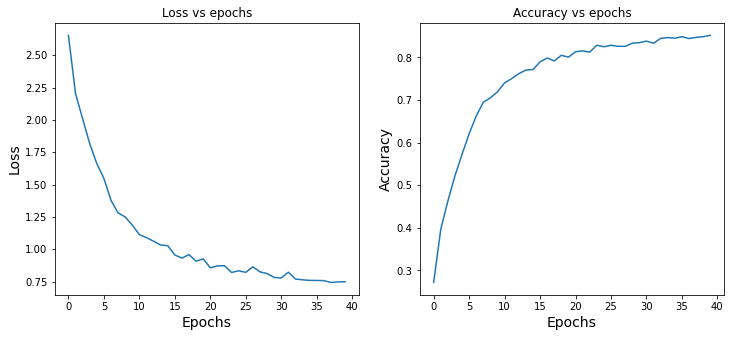

In [20]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(train_loss_results)

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [21]:
def test_model(model, test_generator):

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    train_steps_per_epoch = test_generator.n // test_generator.batch_size
    i = 0
    for x, y in test_generator:
        model_output = model(x)
        epoch_loss_avg(loss_obj(y, model_output))  
        epoch_accuracy(y, model_output)
        if i>=train_steps_per_epoch:
            break
        i+=1
    
    print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
    print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

In [22]:
print('ResNet Model')
test_model(resnet_model, validation_generator)
print('Benchmark Model')
test_model(benchmark_model, validation_generator)

ResNet Model
Test loss: 0.787
Test accuracy: 80.945%
Benchmark Model
Test loss: 1.067
Test accuracy: 75.607%


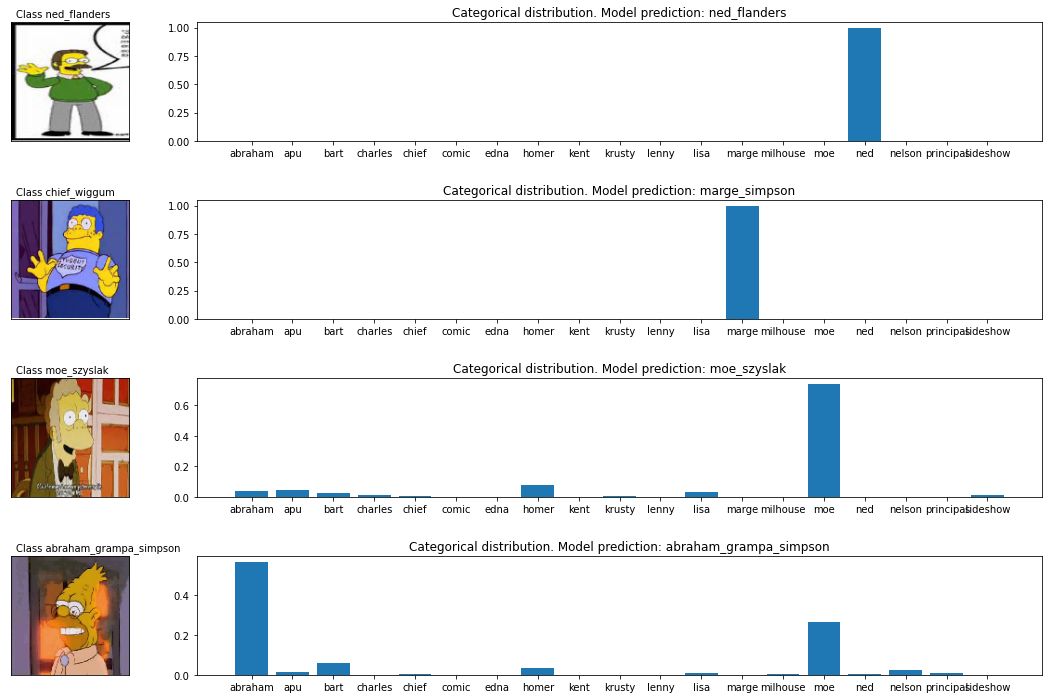

In [24]:
num_test_images = validation_generator.n

random_test_images, random_test_labels = next(validation_generator)

predictions = resnet_model(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(25, 12))
fig.subplots_adjust(hspace=0.5, wspace=-0.35)

j=0
for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, target_labels[(tf.argmax(random_test_labels, axis=1).numpy())])):
    if j >3:
        break
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(5., -7., f'Class {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_xticklabels([l.split('_')[0] for l in target_labels], rotation=0)
    pred_inx = np.argmax(prediction)
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {target_labels[pred_inx]}")
    j+=1
plt.show()

# 6. Conclusion

Residual networks introduced a systematic approach to use *shortcut connections* by simply performing identity mapping. This was proven to stabilize the optimization process of deep networks. The residual network showed the power of shortcut connections by outperforming a traditional CNN.

The approach can be extended by increasing the depth of the model. This is particularly suitable as residual networks do not suffer from the degradation problem.

# 7. References

[[1]](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) [Krizhevsky et al., 2012] Krizhevsky, A., Sutskever, I., and Hinton, G. E. (2012). Imagenet clas-sification with deep convolutional neural networks.Advances in neural information processingsystems, 25:1097–1105.

[[2]](https://arxiv.org/pdf/1512.03385.pdf) [He et al., 2015] He, K., Zhang, X., Ren, S., and Sun, J. (2015). Deep residual learning for imagerecognition.

[[3]](https://arxiv.org/abs/1603.05027) [He et al., 2016] He, K., Zhang, X., Ren, S., and Sun, J. (2016). Identity mappings in deep residualnetworks.

[[4]](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset) https://www.kaggle.com/alexattia/the-simpsons-characters-dataset

[[5]](https://towardsdatascience.com/transfer-learning-and-data-augmentation-applied-to-the-simpsons-image-dataset-e292716fbd43) https://towardsdatascience.com/transfer-learning-and-data-augmentation-applied-to-the-simpsons-image-dataset-e292716fbd43